Trying to fit this model to an anime generator

## Setup

In [80]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from cs231n.gan_pytorch import Flatten, Unflatten, initialize_weights
from cs231n.gan_pytorch import get_optimizer
from cs231n.gan_pytorch import sample_noise
from cs231n.gan_pytorch import bce_loss, discriminator_loss, generator_loss

import warnings

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from cs231n.gan_pytorch import preprocess_img, deprocess_img, rel_error, count_params, ChunkSampler

answers = dict(np.load('gan-checks-tf.npz'))

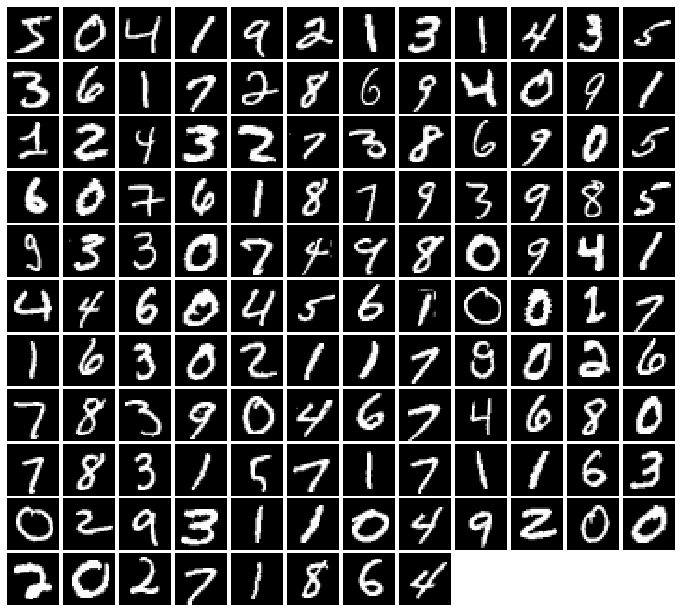

In [3]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Start of Anime GAN Testing

In [4]:
# globals
DIR = '~/Desktop/anime-faces/archive/'
BATCH = 128
NUM_TRAIN = 20000
NUM_VAL = 5000
IMG_SIZE=64
dtype = torch.FloatTensor
real_label = 1
fake_label = 0

In [5]:
imgSet = ImageFolder(DIR, transform= T.Compose([
    T.Resize(IMG_SIZE),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor()
]))

(-0.5, 63.5, 63.5, -0.5)

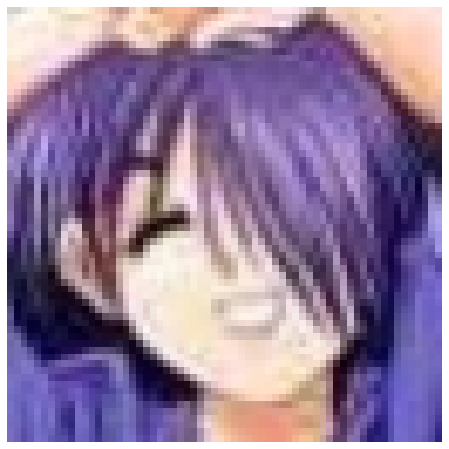

In [6]:
anime_train = DataLoader(imgSet, batch_size=BATCH, sampler=ChunkSampler(NUM_TRAIN, 0))
anime_val = DataLoader(imgSet, batch_size=BATCH, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

imgs = anime_train.__iter__().next()[0].view(-1, 3 * 64 * 64).numpy().squeeze()
images = anime_train.__iter__().next()[0]
plt.imshow(images[0].permute(1, 2, 0))
plt.axis('off')

In [7]:
def build_dc_classifier(batch_size):
    model = nn.Sequential(
    	Unflatten(N=batch_size, C = 3, H=64, W=64),
    	nn.Conv2d(3, 32, kernel_size = 5, stride = 1), # 64 - 5 / 1 + 1 = 60
    	nn.LeakyReLU(0.01), 
    	nn.MaxPool2d(2, stride = 2), # 60 - 2 / 2 +1 = 30
    	nn.Conv2d(32, 64, kernel_size=5, stride = 1), # 30- 5 / 1 + 1 = 26
    	nn.LeakyReLU(0.01),
    	nn.MaxPool2d(2, stride=2), # 26  2 / 2 + 1 = 13
    	Flatten(),
    	# out_channel * H3 * W3
    	nn.Linear(13* 13* 64, 13* 13* 64),
    	nn.LeakyReLU(0.01),
    	nn.Linear(13* 13 *64, 1)
    )
    return model

In [8]:
# need to use n * 4 but why??,e.g. 7 -> 2352, 8 ->3072
# i think it is because of the convtranpose2d; it expands the values and there should be a formula for it
def build_dc_generator(noise_dim=NOISE_DIM):
    # print(noise_dim, NOISE_DIM)
    model = nn.Sequential(
    	nn.Linear(noise_dim, 4096),
    	nn.ReLU(),
    	nn.BatchNorm1d(4096),
    	nn.Linear(4096, 128 * 16 * 16),
    	nn.ReLU(),
    	nn.BatchNorm1d(128 * 16 * 16),
    	Unflatten(-1,128,16,16),
    	nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
    	nn.ReLU(),
    	nn.BatchNorm2d(64),
    	nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
    	nn.Tanh(),
    	Flatten()
    )
    return model

In [9]:

def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, loader_train, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
#     The logic of the function is as follows:
#     1. zero out the gradients for d_solver
#     2. train the discriminator on the real data and get the scores
#     3. generate fake images and then train the discriminator on those fake images and get the scores
#     4. calculate the loss of the fake and real images and do a backward pass on the discriminator
#     5. create new fake images and do a forward pass on the images with the generator
#     6. run the fake data through the discriminator
#     7. calculate the loss based on output from the discriminator and do a backward pass

    images = []
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 3, 64, 64))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 3, 64, 64))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                images.append(imgs_numpy[0:16])

            iter_count += 1
    
    return images

# END OF ANIME GAN TESTING

In [10]:

data = next(enumerate(anime_train))[-1][0].type(dtype)
b = build_dc_classifier(BATCH).type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


In [11]:
test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(BATCH, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 12288])

In [12]:
D_DC = build_dc_classifier(BATCH).type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, anime_train, num_epochs=5, show_every=100)

Iter: 0, D: 1.42, G:53.91
Iter: 100, D: 1.198, G:0.9982
Iter: 200, D: 1.958, G:1.517
Iter: 300, D: 1.22, G:1.101
Iter: 400, D: 1.525, G:2.398
Iter: 500, D: 1.151, G:0.9181
Iter: 600, D: 1.307, G:0.3514
Iter: 700, D: 1.199, G:1.073


In [48]:
im_copy = images.copy()

In [49]:
images[-1][-1].shape

(12288,)

In [50]:
test1 = images[0][0].reshape(3,64,64)
test2 = images[-1][-1].reshape(3,64,64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


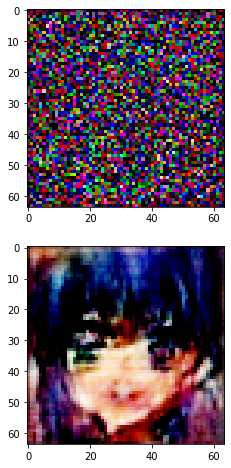

In [51]:
fig, axs = plt.subplots(2)
axs[0].imshow(test1.transpose(1,2,0))
axs[1].imshow(test2.transpose(1, 2, 0))

In [115]:
from torchvision.utils import save_image
import imageio

In [117]:
imageio.imwrite('~/Desktop/anime-faces/testing2.png', test2.transpose(1,2,0))
# save_image(test1.transpose(1,2,0), '~/Desktop/anime-faces/testing.png')

Lossy conversion from float32 to uint8. Range [-0.9795127511024475, 0.9916417002677917]. Convert image to uint8 prior to saving to suppress this warning.


In [126]:
import logging

# logger = logging.getLogger()
# old_level = logger.level
# logger.setLevel(100)

# # plotting code here

# logger.setLevel(old_level)
def show_image(images):    
    rows = 4
    cols = 4
    itrcount = 0
    for i in range(len(images)):
        
        logger = logging.getLogger()
        old_level = logger.level
        logger.setLevel(100)
        
        fig = plt.figure(figsize=(8,8))
        img = images[i].reshape(images[i].shape[0], 3, 64, 64)
        print("Iteration is ", itrcount)
        itrcount += 100
        for j in range(img.shape[0]):
            fig.add_subplot(rows, cols, j+1)
#             plt.imshow((img[j].transpose(1,2,0)* 255).astype(np.uint8))
            plt.imshow(img[j].transpose(1,2,0))
        plt.show()
        logger.setLevel(old_level)

Iteration is  0


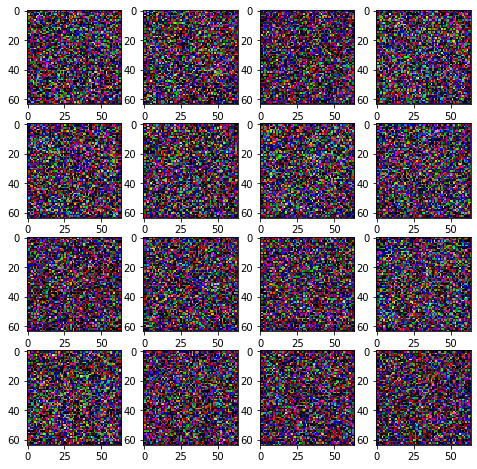

Iteration is  100


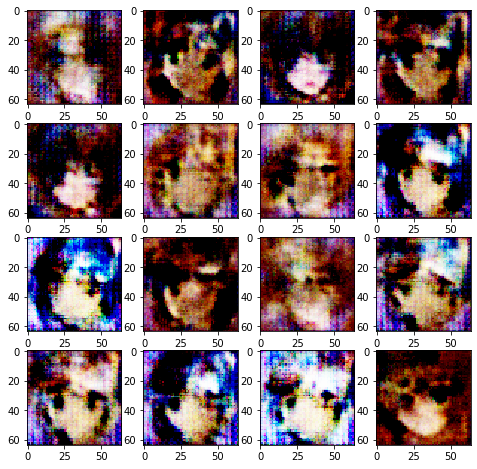

Iteration is  200


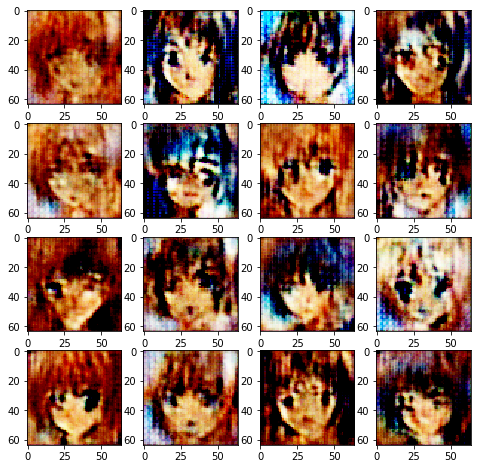

Iteration is  300


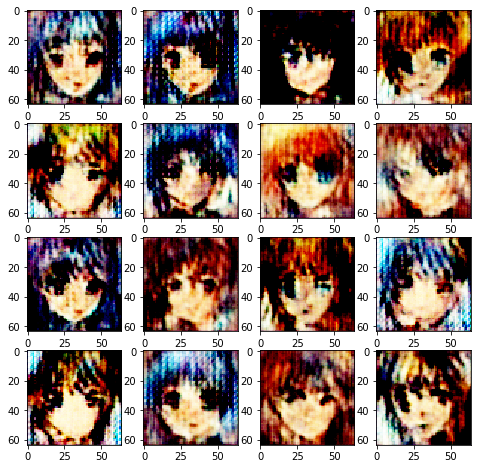

Iteration is  400


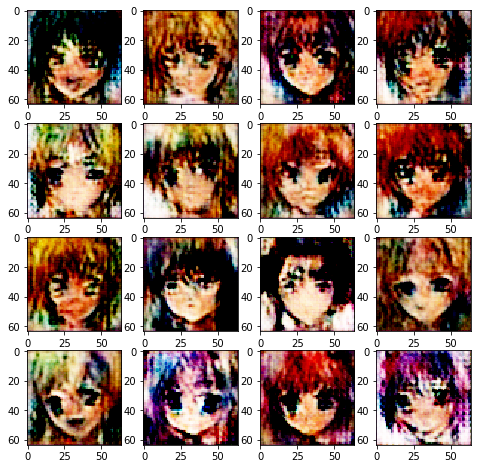

Iteration is  500


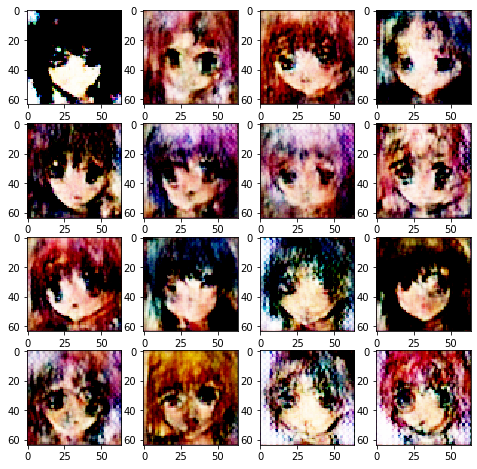

Iteration is  600


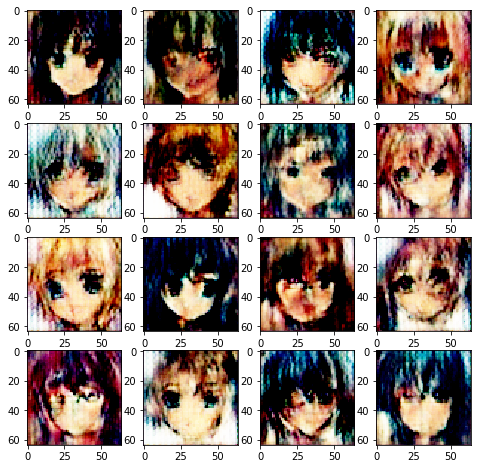

Iteration is  700


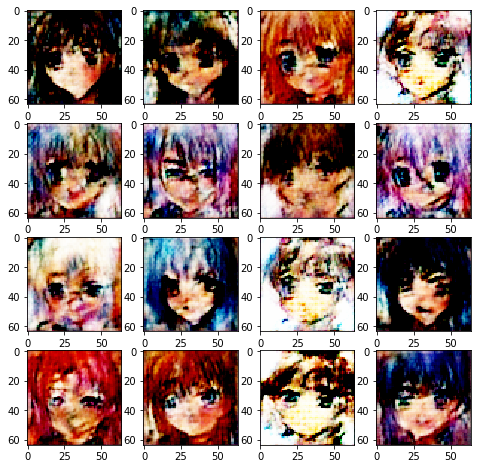

In [127]:
warnings.filterwarnings("ignore", module="matplotlib")
show_image(images)

In [145]:
# saving images
def save_image(images):    
    for i in range(len(images)):
        img = images[i].reshape(images[i].shape[0], 3, 64, 64)
        for j in range(img.shape[0]):
            filename = '~/Desktop/anime-faces/faces1/animeface-'+str(i*16+j)+'.png'
            imageio.imwrite(filename, img[j].transpose(1,2,0))


In [146]:
warnings.filterwarnings("ignore")
save_image(images)

In [148]:
torch.save(D_DC.state_dict(), '/home/ghost/Desktop/anime-faces/models/discriminator1.pkl')
torch.save(G_DC.state_dict(), '/home/ghost/Desktop/anime-faces/models/generator1.pkl')